## What's the best time of day to post to tiktok?

My wife downloaded tiktok last year when we were deep into quarantine and it felt like it was never going to end. 
One of her first videos went viral, it's up near 7 figure views as this point. I'll go on the record saying she's 
creative enought to earn that and for now let's all pretend that there's nothing malicious on [TikToks part about that](https://twitter.com/ChrisWillx/status/1351840551033778176).
Regardless, she was hooked.

Before long, she was spending hours in front of a ring light building up content inventory like a true creator. Usually this
meant a Sunday afternoon where she'd make 3-4 videos that she could post througout the week. The key of course, is 
to pick strategic times to post that content. There's an ROI to achieve here.

A google search will reveal a table with the 'best' times to post. With the growth of influencer marketing and social media
as a hobby I figured she'd find a website dedicated to such strategy. In reality,  we found sparse details being pitched
as surefire. That google search will point you to to one company who claims to have analyzed 100k+ videos.
All they provide is a list of a few times. All the other search results point to the same article. 

I think this is far from sufficient in answering the question. I also think it's a great open source opportunity for a 
transparent analysis.

The following outlines my analysis of when to post to tiktok. I've looked at ~175 users, and ~9000 videos. I outline the analysis and I have provided explanations for the corresponding python code.

In [6]:
import datetime as dt
import pickle
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

The only import i'll call out is scikitlearn's MinMaxScaler class. I'll discuss this more when I use it.

I'm not including the code I used to pull the data from tiktok in this summary. 
It's available in the repository for review. I used David Teather's unofficial [tiktok api](https://github.com/davidteather/TikTok-Api). 
He provides decent documentation and I didn't do much on top of using the basic methods. 
So below I'm just importing a pickle, which is the outcome of the data sourcing script.

A quick summary of that data pull
    -Randomly select handful of accounts
    -Pull in 30 "suggested by tik tok" users for each "starter" selection
    -Select the last 50 videos from all of these users
    -This equates to ~9000 videos and 177 users.
    
Given tiktok doesn't have an official API I can use to pull this info, it's been inconsistent when I try to scale the dataset.
I plan to continue improving the data pull so that I can grow the sample size here.

In [7]:
#Read in data
pkl_file = open('tiktoklist3.pickle', 'rb')
tiktok_pkl = pickle.load(pkl_file)

Transform the dictionary in the pickle to a pandas dataframe. Each value is a different video, where we can use the video_id as the index. Each video has a user and that user's number of follower, called fans by tiktok developers. I've also brought in 
the views and time it was posted.

For my analysis I've decided to use views as the KPI. An alternative approach might be to measure engagement. I haven't studied
Tiktok's algorithm in detail. A skim across the internet will tell you it rewards videos for engagement. If you're trying to
monetize your channel engagement is also important. However, in the end I think the average person is chasing views. Given most
people aren't making money of tiktok, engagement seems to be inferior. 

In [16]:
#Create Dataframe
tiktoks = pd.DataFrame.from_dict(tiktok_pkl,orient='index')
tiktoks.index.name = 'video_id'
tiktoks.head()

,user,fans,views,posttime
video_id,,,,
6929135730618879237,6700343527676740613,5800000,95200,1613315144
6928770891627121926,6700343527676740613,5800000,1800000,1613230198
6928372946792664326,6700343527676740613,5800000,218200,1613137548
6928012472490265861,6700343527676740613,5800000,143000,1613053619
6927642059599908102,6700343527676740613,5800000,265400,1612967376


I always check for duplicates, data is never as clean as you think it is.

In [9]:
##Prints Duplicates if any and then drops them
tiktoks.loc[tiktoks.duplicated()]

,user,fans,views,posttime
video_id,,,,


In [ ]:
##Drop Duplicates
tiktoks = tiktoks.drop_duplicates()

In [23]:
## Drop anyone with < 5 videos, not enough sample size for normalization
tikgroup = tiktoks.groupby(by='user').count().sort_values(by='posttime')
tikgroup = tikgroup.loc[tikgroup['posttime'] < 5]
ul = tikgroup.index

for user in ul:
    to_drop = tiktoks.loc[tiktoks['user'] == user].index
    tiktoks.drop(to_drop,inplace=True)

## Adding Features
Given we're doing a review of when to post, I've done some up front work to make datetime features easily accesible in our dataframe.

In [24]:
##Add a few variables
tiktoks['posttime'] = pd.to_datetime(tiktoks['posttime'],unit='s')
tiktoks['date'] = tiktoks['posttime'].dt.date
tiktoks['hour'] = tiktoks['posttime'].dt.hour
tiktoks['day'] = tiktoks['posttime'].dt.weekday

Before we go any further on the time analysis, I want to understand the users of these videos. This is important because of
the stark differences in the people who view videos vs the people creating those videos.

In [25]:
##Let's also split users up by their fan count
user_df = tiktoks.drop_duplicates(subset=['user']).loc[:,['user','fans']].reset_index(drop=True)

user_df.sort_values(by=['fans'])
##plt.hist(tiktoks['fans'])   

,user,fans
166,2.253951e+17,1247
163,6.761958e+18,8475
152,2.259336e+17,11000
25,6.709482e+18,13400
154,2.886850e+07,14600
...,...,...
107,2.464515e+07,27600000
93,6.616242e+18,29500000
35,6.745192e+18,32600000
32,6.727327e+18,48000000


## Data Normalization
We have a user with 51 million followers and one with 1200 followers. It's not really a fair if we compare the views
for these two people.

What we need to do is normalize that date.

An oversimplified explanation is that we need to match the scale for all users. 
I need to transform all views to be between 0 and 1 for each user, where 1 is their highest viewed video. 

If 1 is the best for each individual, I can compare each users 1 as equivalents.

In [26]:
##Alter a few datatypes for series - necessary for scikitlearn method
tiktoks['user'] = tiktoks['user'].astype('float64')
tiktoks['views'] = tiktoks['views'].astype('float64')

I'll need to tell the scaler that we're scaling many subsets. We don't want it to convert all video views on the same
0 to 1 scale. We will need to reset what 1 is for every user. To do that, we need a list of unique users to iterate through.

In [27]:
##Create list of unique values to iterate through for normalization
user_list = user_df['user']
user_list

0      6.700344e+18
1      6.866499e+18
2      6.805365e+18
3      6.648626e+18
4      6.793185e+18
           ...     
167    6.767040e+18
168    6.841663e+18
169    6.746036e+18
170    6.786296e+18
171    6.815256e+18
Name: user, Length: 172, dtype: float64

In [28]:
##Scale views by tiktok author - this prevents big accounts from outweighing smaller creators
scaler = MinMaxScaler()

for user in user_list:
        norm_data = scaler.fit_transform(tiktoks.loc[tiktoks['user'] == user]['views'].values.reshape(-1, 1))
        tiktoks.loc[tiktoks['user'] == user,'norm_data'] = norm_data

In [42]:
##This is a demonstration of what numpy reshape does for the feature scaling. 
#The list needs to be a series of one value lists
#.values will turn the series into an np array
#.reshape turns each value in the array into it's own list and creates a list of lists
# I'm just selecting the top 10 in the list for brevity
tiktoks.loc[tiktoks['user'] == 6805364861930783749]['views'].values.reshape(-1, 1)[0:9]

array([[ 434300.],
       [  54000.],
       [  53200.],
       [  32200.],
       [  99000.],
       [ 332700.],
       [3100000.],
       [4100000.],
       [ 152300.]])

## Analysis

We have now modified and cleaned the data! Time to evaluate when one should post.

First let's understand how often people have viral videos. 

(array([6273.,  839.,  349.,  191.,  113.,   59.,   34.,   43.,   32.,
         189.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

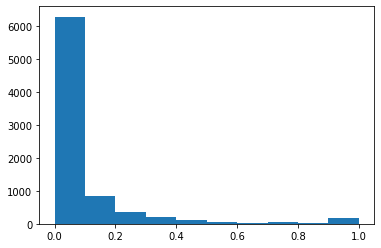

In [44]:
plt.hist(tiktoks['norm_data'])

This is about what I expected. People have a few viral videos that get exponentially higher amounts of views than their
normal videos. The bulk of your time is spent on videos that won't have near the success of that dopamine rush you got
when a video blew up.

The bins on the x-axis for the histogram above are auto generated by matplotlib. I want to manually assign these bins
to the videos in our dataframe so that we can use them in other views. 

In [50]:
#Add bins to data
binned = pd.cut(tiktoks['norm_data'], [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01 ],include_lowest=True, right=True).value_counts()
tiktoks['bin'] = pd.cut(tiktoks['norm_data'], [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01 ],include_lowest=True, right=True)

I can pivot on the bins now to see the count of vidoes per bin. From there I can see what percent of videos are made up
of each bin. This will put a more concerte number on the observation from the histogram.

87% of all videos are <.2. 

In [51]:
bincount = pd.pivot_table(tiktoks,index='bin',values='user',aggfunc='count')
bincount['perc']=bincount['user']/bincount['user'].sum()
bincount

,user,perc
bin,,
"(-0.001, 0.1]",6273,0.772347
"(0.1, 0.2]",839,0.103300
"(0.2, 0.3]",349,0.042970
"(0.3, 0.4]",191,0.023516
"(0.4, 0.5]",113,0.013913
"(0.5, 0.6]",59,0.007264
"(0.6, 0.7]",34,0.004186
"(0.7, 0.8]",43,0.005294
"(0.8, 0.9]",32,0.003940


While the number of videos that are viral, let's define viral as > .8, that doesn't necessarily correspond 
with their impact on total views.

Let's see the mix of views by bin.

In [52]:
bindf = pd.pivot_table(tiktoks,index='bin',values='views',aggfunc='sum')
bindf['perc'] = bindf['views']/bindf['views'].sum()
bindf

,views,perc
bin,,
"(-0.001, 0.1]",3.077338e+09,0.258511
"(0.1, 0.2]",1.926542e+09,0.161839
"(0.2, 0.3]",1.657502e+09,0.139238
"(0.3, 0.4]",7.277713e+08,0.061136
"(0.4, 0.5]",6.480738e+08,0.054441
"(0.5, 0.6]",3.580224e+08,0.030076
"(0.6, 0.7]",3.091275e+08,0.025968
"(0.7, 0.8]",5.639969e+08,0.047378
"(0.8, 0.9]",1.564329e+08,0.013141


Viral videos represent, 22% of all views. Really that's concentrated in the biggest video each user has, their >.9 events.

What stands out to me is the .2-.3 group. While only 4.3% of videos, they're 13.9% of views. 

We can graph a comparison between a bins video count and it's mix of views. The larger the gap the bigger the discrepancy.

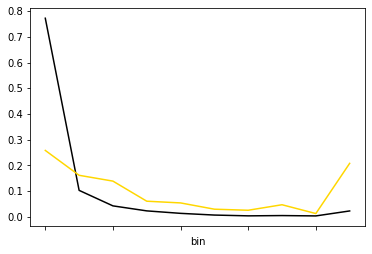

In [59]:
#Count of views by bin
bincount['perc'].plot(color='black')

#Count of vidoes by bin
bindf['perc'].plot(color='gold')

I find this is helpful in evaluating what we're looking for as a result of when the video is posted.

We want to keep the video's views in mind but we also want to understand it's ability to go viral. 

I want to get some bearings on how the data looks by seeing normalized performance by hour the video was posted.

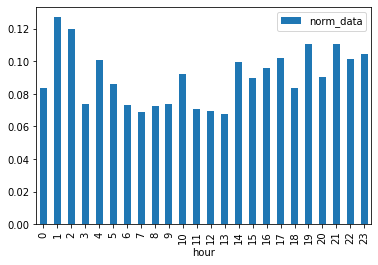

In [60]:
hourly_data = pd.pivot_table(tiktoks,index='hour',values='norm_data',aggfunc='mean')
hourly_data.plot(kind='bar')

That's pretty noisy but there seems to be a pattern of lower performance between 5am and 1pm.

After 1pm, it picks up significantly.

I'm using the mean here. Knowing that we have significant tail events (viral videos), that's not the ideal way to 
look at averages. Let's do the same thing but with median.

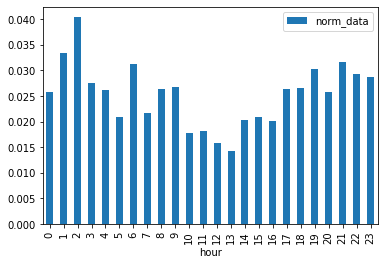

In [62]:
hourly_data = pd.pivot_table(tiktoks,index='hour',values='norm_data',aggfunc='median')
hourly_data.plot(kind='bar')

This exagerrates the difference between mid morning performance that, again, start to pick up after 1pm. 

Important to note on the 2nd chart is the x axis. The difference in the low hours (.015) and evening (.3) is 100%.

When looking at the mean it's only 40%!

There's a lot of volatility between hours. 2am and 6am are meaningfully higher than their neighboring spots on the clock.

Let's make sure sample size isn't affecting this.

In [63]:
pd.set_option('display.max_rows',30)

tiktoks['hour'].value_counts().sort_index()

0     432
1     438
2     409
3     341
4     206
5     188
6     167
7     132
8     107
9     105
10    118
11    154
12    166
13    178
14    288
15    367
16    473
17    506
18    623
19    639
20    687
21    542
22    444
23    412
Name: hour, dtype: int64

There's a handfull of interesting obersvations here.

-Given everything is >100 videos, i'm comfortable with the sample size. Some of the fluctuations will smooth with larger sample size but  there's nothing egregous here

-We can see some trends about when people are posting to Tiktok. Most videos are posted from 4pm-2am EST.Peak his 6-8pm EST.

An interesting hypothesis might be:
> Videos posted when there is less competition from other new videos will perform better

That's banking on a supply/demand equilibrium being the driver. 

Let's visualize when videos are being posted.

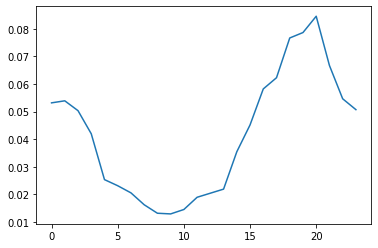

In [64]:
p1 = tiktoks['hour'].value_counts().sort_index()/tiktoks['hour'].value_counts().sum()
p1.plot()

If you compare this to our median normalized performance chart, they're pretty similar. It seems that videos perform worse
at the same time a day less videos are posted. Glad to see tiktokers are getting at least some sleep.

Let's revisit this view but focusin on viral videos.

When are most viral videos posted?

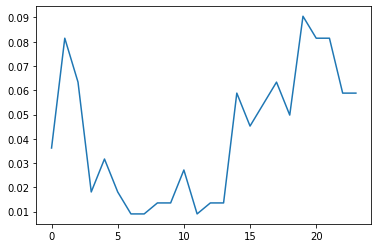

In [66]:
tiktoks.loc[tiktoks['norm_data']>=.8]['hour'].value_counts().sort_index()/tiktoks.loc[tiktoks['norm_data']>=.8]['hour'].value_counts().sum()
p2 = tiktoks.loc[tiktoks['norm_data']>=.8]['hour'].value_counts().sort_index()/tiktoks.loc[tiktoks['norm_data']>=.8]['hour'].value_counts().sum()
p2.plot()

Interesting, it follow the same pattern but with the lows and highs exaggerated. You're really not likely to post something
viral between 3am and 1pm. 

Let's compare when viral vidoes are posted to when all videos are posted. If there is a large gap at any time it would point
us to the conclusion that you're video is more likely to go viarl if posted at that time.

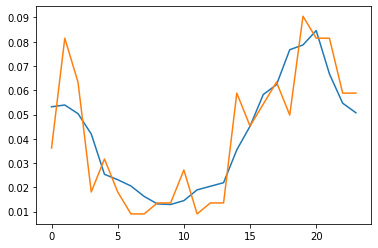

In [68]:
p1.plot()
p2.plot()

One assumption i've been making without discussing is that hours are always the same.

Let's test that out and look at performance by day. 2am Tuesday morning and 2am sunday morning are very different animals.

As a note here, throughout this workbook I've done essentialy no formatting of charts. That's a conscious decision but it'll finally bite me in the butt here. It's hard to interpret 0 and 1 as days.

For reference, 0 is Monday and 6 is Sunday. So think of 4,5,6 as the weekend (including Friday for Friday night here).

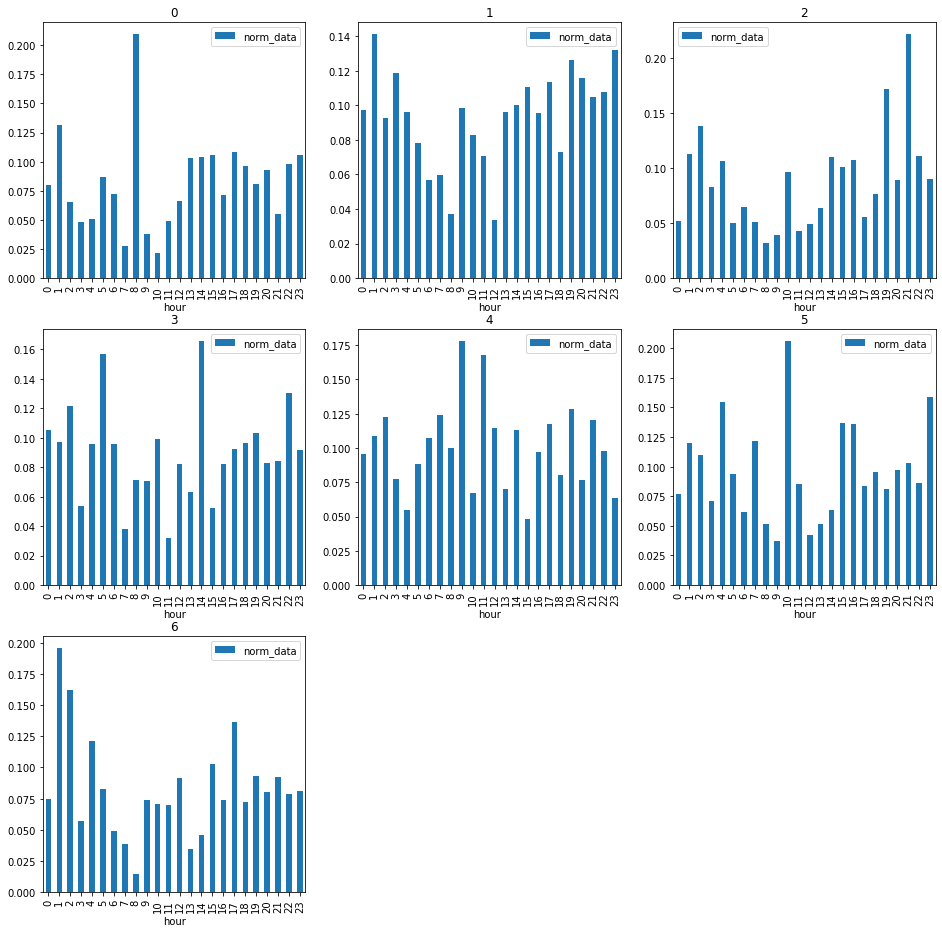

In [70]:
##Show best time of day to post by day

fig = plt.figure(figsize=(16,16))
for day in range(0,7):
    ax = fig.add_subplot(3,3,day+1)
    pd.pivot_table(tiktoks.loc[tiktoks['day'] == day],index='hour',values='norm_data',aggfunc='mean').plot(kind='bar', ax=ax)
    ax.set_title('{}'.format(day))
    
plt.show()

Sample size will be an issue here. I'm taking ~9000 videos and dividing them into 168 bins. If they were evently distributed it would be ~50 per hour but we know from earlier they're far from evenly distributed. 

Still, we can see the same basic pattern across days. A dip mid-day and high performance in the evening hours.

The y scales don't match across these charts. It's hard to compare days. Let's see if there is better performance on specific days.

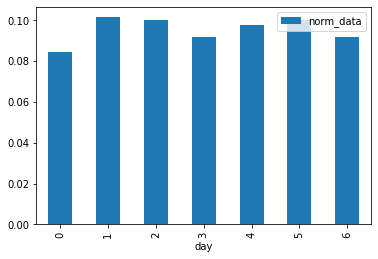

In [72]:
##Best day of the week to post
pd.pivot_table(tiktoks,index='day',values='norm_data',aggfunc='mean').plot(kind='bar')

And let's expand that to look at viral videos.

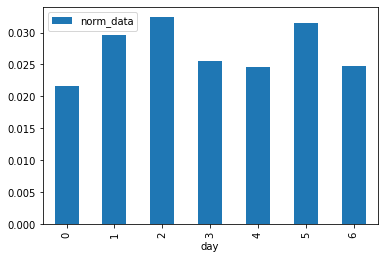

In [75]:
#day of week when viral videos are posted
#Takes count by day for viral videos and divides by total vidoes posted by day to give us a %.
ratio = pd.pivot_table(tiktoks.loc[tiktoks['norm_data']>=.8],index='day',values='norm_data',aggfunc='count')/pd.pivot_table(tiktoks,index='day',values='norm_data',aggfunc='count')
ratio.plot(kind='bar')

On Mondays, 2% of all vidoes will go viral. 

On Tuesdays, Wednesdays, and Saturdays; 3% of videos will go viral. A 50% increase in likelihood!!

## Summary

One assumption not addressed to day is the causuality of when the video was posted. I'm assuming a video performed better
*because* it was posted at that time. However, creators might post their best content at a specific time. The quality of the
content might be the underlying driver, not the time. Quantifying the quality of a video is beyond the scope of this analysis, so I'll move forward with that assumption.

- Avoid posting between 4am and 1pm EST. 

- The best performing videos, especially if you want to go viral, are posted between 1am and 3am EST.
    - I don't have access to when the "view" occurs. I'm very interested to see if these are going viral because of views the    following day ore because of 1am and 3am views...
    
- Videos posted between 6 and 10pm EST are a close second on performance

- If you want to go viral, post on Tuesday, Wednesday and Saturday!

- Monday's are the worst performing days. If you have limited content, try to avoid Mondays.
    - If you are posting no matter what on Monday (most serious creators) make sure you wait until after 1pm EST
    


